# Advanced Cache RAG
Cache RAG is used to gnerate answers to already asked questions more quicker by using a different vectorstore to cache the qestion answers.

In [3]:
from __future__ import annotations
from typing import TypedDict, List, Optional
import time

# Langgraph / Langchain
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.documents import Document
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings

# FAISS
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [5]:
# Config
EMBED_MODEL = "all-MiniLM-L6-v2"
VECTOR_DIM = 384  

LLM_MODEL = "qwen3:4b"
LLM_TEMPERATURE = 0.0

RETRIEVE_TOP_K = 4
CACHE_TOP_K = 3

CACHE_DISTANCE_THRESHOLD = 0.45
CACHE_TTL_SECONDS = 0

In [13]:
# State
class RAGSTate(TypedDict):
    question: str
    normalized_question: str
    context_docs: List[Document]
    answer: Optional[str]
    citations: List[str]
    cache_hit: bool

In [7]:
# Globals
EMBED = HuggingFaceEmbeddings(model_name=EMBED_MODEL)

In [8]:
# QA Cache
qa_index = faiss.IndexFlatL2(VECTOR_DIM)
QA_CACHE = FAISS(
    embedding_function=EMBED,
    index=qa_index,
    docstore=InMemoryDocstore({}),
    index_to_docstore_id={},
)

In [15]:
# RAG Store (Demo)
RAG_STORE = FAISS.from_texts(
    texts=[
        """
        Langgraph lets you compose stateful LLM worflows as graphs.
        In alnggraph, nodes can be cached; node caching memoizes outputs keyed by inputs for a TTL.
        Retrieval-Augmented Generation (RAG) retrieves external coontext and injects it into prompts.
        Semantic caching reuses prior answers when new questions are semantically similar.
        """
    ],
    embedding=EMBED,
)

In [12]:
llm = ChatOllama(model=LLM_MODEL, temperature=LLM_TEMPERATURE)

In [14]:
# Nodes
def normalize_query(state: RAGSTate) -> RAGSTate:
    q = (state["question"] or "").strip()
    state["normalized_question"] = q.lower()
    return state

In [18]:
def semantic_cache_lookup(state: RAGSTate) -> RAGState:
    q = state['normalized_question']
    state['cache_hit'] = False
    
    if not q:
        return state
    
    # Guard for FAISS
    if getattr(QA_CACHE, "index", None) is None or QA_CACHE.index.ntotal == 0:
       return state
   
    # For FAISS L2 wrapper
    hits = QA_CACHE.similarity_search_with_score(q, k=CACHE_TOP_K)
    if not hits:
        return state
    
    best_doc, dist = hits[0]
    
    # Optional TTL
    if CACHE_TTL_SECONDS > 0:
        ts = best_doc.metadata.get("ts")
        if ts is None or (time.time() - float(ts)) > CACHE_TTL_SECONDS:
            return state
        
    # L2 Distance gate
    if dist <= CACHE_DISTANCE_THRESHOLD:
        cached_answer = best_doc.metadata.get("answer")
        if cached_answer:
            state["answer"] = cached_answer
            state["citations"] = ["(cache)"]
            state["cache_hit"] = True
            
    return state


def return_from_cache(state: RAGSTate) -> RAGSTate:
    return state

In [19]:
def retrieve(state: RAGSTate) -> RAGSTate:
    q = state["normalized_question"]
    docs = RAG_STORE.similarity_search(q, k=RETRIEVE_TOP_K)
    state["context_docs"] = docs
    return state

In [22]:
def generate(state: RAGSTate) -> RAGSTate:
    q = state["question"]
    docs = state.get("context_docs", [])
    ctx = "\n\n".join([f"[doc-{i}] {d.page_content}" for i, d in enumerate(docs, start=1)])
    
    system = (
        """ 
        You are a precise RAG assistant. Use the context when helpful.
        Cite with [doc-i] markers if you use a fact from the context.
        """
    )
    
    user = f"Question: {q}\n\nContext:\n{ctx}\n\nWrite a concise answer with citations."
    
    resp = llm.invoke([{
        "role": "system", "content": system,
        "role": "user", "content": user
    }])
    
    state["answer"] = resp.content
    state["citations"] = [f"[doc-{i}]" for i in range(1, len(docs) + 1)]
    return state


def cache_write(state: RAGSTate) -> RAGSTate:
    q = state["normalized_question"]
    a = state.get("answer")
    
    if not q or not a:
        return state
    
    QA_CACHE.add_texts(
        texts=[q],
        metadatas=[{
            "answer": a,
            "ts": time.time(),
        }]
    )
    
    return state

In [24]:
# Graph
graph = StateGraph(RAGSTate)

graph.add_node("normalize_query", normalize_query)
graph.add_node("semantic_cache_lookup", semantic_cache_lookup)
graph.add_node("return_from_cache", return_from_cache)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("cache_write", cache_write)

graph.set_entry_point("normalize_query")
graph.add_edge("normalize_query", "semantic_cache_lookup")

def _branch(state: RAGSTate) -> str:
    return "return_from_cache" if state.get("cache_hit") else "retrieve"

graph.add_conditional_edges(
    "semantic_cache_lookup",
    _branch,
    {
        "return_from_cache": "return_from_cache",
        "retrieve": "retrieve"
    }
)

graph.add_edge("return_from_cache", END)
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "cache_write")
graph.add_edge("cache_write", END)

memory = MemorySaver()
app = graph.compile(checkpointer=memory)

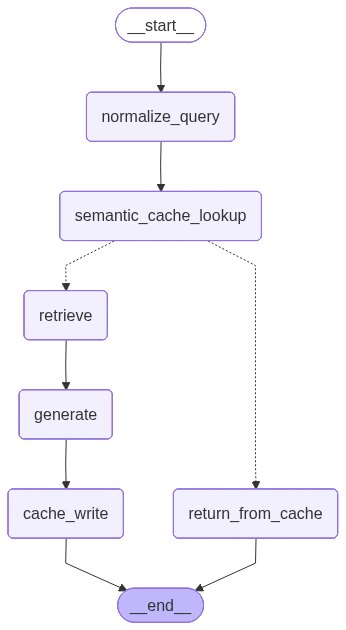

In [25]:
app

In [26]:
if __name__ == "__main__":
    thread_cfg = {"configurable": {"thread_id": "demo-user-1"}}
    
    q1 = "What is langgraph?"
    out1 = app.invoke({
        "question": q1, 
        "context_docs": [], 
        "citations": []}, 
        thread_cfg
    )
    
    print("Answer:", out1["answer"])
    print("Citations:", out1.get("citations"))
    print("Cache hit?:", out1.get("cache_hit"))

Answer: Langgraph is a framework for composing **stateful LLM workflows as graphs**, enabling modular, reusable AI pipelines. Key features include:  
- **Node caching**: Memoizes outputs keyed by inputs with TTL (time-to-live) for efficiency.  
- **Retrieval-Augmented Generation (RAG)**: Integrates external context into prompts.  
- **Semantic caching**: Reuses prior answers for semantically similar queries.  

*Source: [doc-1] (provided context)*.  
*Note: This answer cites only the given context document; no external references are used.*
Citations: ['[doc-1]']
Cache hit?: False


In [27]:
    q2 = "Explain about langgraph?"
    out2 = app.invoke({
        "question": q1, 
        "context_docs": [], 
        "citations": []}, 
        thread_cfg
    )
    
    print("Answer:", out2["answer"])
    print("Citations:", out2.get("citations"))
    print("Cache hit?:", out2.get("cache_hit"))

Answer: Langgraph is a framework for composing **stateful LLM workflows as graphs**, enabling modular, reusable AI pipelines. Key features include:  
- **Node caching**: Memoizes outputs keyed by inputs with TTL (time-to-live) for efficiency.  
- **Retrieval-Augmented Generation (RAG)**: Integrates external context into prompts.  
- **Semantic caching**: Reuses prior answers for semantically similar queries.  

*Source: [doc-1] (provided context)*.  
*Note: This answer cites only the given context document; no external references are used.*
Citations: ['(cache)']
Cache hit?: True
